In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# --- 1. Setup and Data Loading ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
# Ensure the file 'swiggy_scrap_uncleaned.csv' is in the same directory.
try:
    df = pd.read_csv('C:/Users/91636/OneDrive/Desktop/Project/swiggy_scrap_uncleaned.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'swiggy_scrap_uncleaned.csv' not found.")
    print("Please ensure the file is in the correct directory.")
    exit()


Dataset loaded successfully.


In [3]:
# Initial exploration of the dataset
print("\n--- Initial Data Overview ---")
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nData types and null value count:")
df.info()



--- Initial Data Overview ---
Dataset shape: (1749, 5)

First 5 rows of the dataset:
                         hotel_name rating_and_delivery_time  \
0                        McDonald's            4.5 • 27 mins   
1                               KFC            4.2 • 30 mins   
2                    Domino's Pizza            4.3 • 25 mins   
3  Charcoal Eats - Biryani & Beyond            4.3 • 24 mins   
4                        Sandwizzaa            4.6 • 22 mins   

                                       food_type        location  \
0             Burgers, Beverages, Cafe, Desserts  Kandivali East   
1  Burgers, Biryani, American, Snacks, Fast Food  Kandivali East   
2              Pizzas, Italian, Pastas, Desserts  Thakur Village   
3      Biryani, Kebabs, Hyderabadi, North Indian  Malad Kan East   
4             Snacks, Fast Food, Beverages, Jain  Kandivali East   

                  offer  
0     30% OFF UPTO ₹75   
1     40% OFF UPTO ₹80   
2  ₹150 OFF ABOVE ₹299   
3    50% OFF UPT

In [4]:
# --- 2. Data Cleaning (using Pandas) ---

# Handling the `rating_and_delivery_time` column, which is complex.
# We will split it into two new, clean columns: 'rating' and 'delivery_time'.

# First, create a new DataFrame to avoid modifying the original data for now
df_clean = df.copy()

In [5]:
# Split the column by ' • '
split_columns = df_clean['rating_and_delivery_time'].str.split(' • ', expand=True)

In [6]:
# Assign the first part to a potential rating column.
# The `str` accessor allows string operations on the Series.
df_clean['rating'] = split_columns[0]

In [7]:
# The second part contains delivery time, but some rows have only delivery time.
# We need to handle this by checking if the original column contains 'mins'.
def get_delivery_time(row):
    if isinstance(row['rating_and_delivery_time'], str) and 'min' in row['rating_and_delivery_time']:
        # If delivery time is in the first part (no rating)
        if 'min' in str(row['rating']):
            return row['rating']
        # If delivery time is in the second part (with rating)
        else:
            return row[1]
    return None

In [8]:
# Apply the function to create a new delivery_time column
df_clean['delivery_time_str'] = split_columns[1].fillna(split_columns[0])

In [9]:
# Clean and convert the `rating` column
# Drop any non-numeric characters and convert to float.
# We extract only the numeric part with a decimal, then convert to float.
df_clean['rating'] = df_clean['rating'].str.extract(r'(\d+\.\d+)').astype(float)
# Replace NaN values (for rows with no rating) with 0 or a placeholder.
df_clean['rating'].fillna(0, inplace=True)


C:\Users\91636\AppData\Local\Temp\ipykernel_10568\3409843502.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['rating'].fillna(0, inplace=True)


In [10]:
# Clean and convert the `delivery_time_str` column
# Extract only the numerical part (handling ranges like '11-21 mins')
df_clean['delivery_time'] = df_clean['delivery_time_str'].str.extract(r'(\d+)')
df_clean['delivery_time'].fillna(0, inplace=True)
df_clean['delivery_time'] = pd.to_numeric(df_clean['delivery_time'], errors='coerce').astype('Int64')


C:\Users\91636\AppData\Local\Temp\ipykernel_10568\2801607212.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['delivery_time'].fillna(0, inplace=True)


In [11]:
# Handling the 'offer' column. We found in previous analysis that
# nulls were replaced by a single space, so we check for that.
df_clean['offer'].replace(' ', np.nan, inplace=True)
df_clean['has_offer'] = df_clean['offer'].notna()

C:\Users\91636\AppData\Local\Temp\ipykernel_10568\2058814447.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['offer'].replace(' ', np.nan, inplace=True)


In [12]:
# Handling the `food_type` column for analysis
# We will create a list of all cuisines and then get counts for the bar plot.
all_cuisines = df_clean['food_type'].str.split(', ').explode().dropna()
cuisine_counts = all_cuisines.value_counts().reset_index()
cuisine_counts.columns = ['cuisine', 'count']

In [13]:
# Remove irrelevant columns
# The original columns are now replaced by cleaner versions.
df_clean.drop(columns=['rating_and_delivery_time', 'offer', 'delivery_time_str'], inplace=True)


In [14]:
print("\n--- Cleaned Data Overview ---")
df_clean.info()
print("\nFirst 5 rows of the cleaned dataset:")
print(df_clean.head())



--- Cleaned Data Overview ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hotel_name     1749 non-null   object 
 1   food_type      1749 non-null   object 
 2   location       1749 non-null   object 
 3   rating         1749 non-null   float64
 4   delivery_time  1749 non-null   Int64  
 5   has_offer      1749 non-null   bool   
dtypes: Int64(1), bool(1), float64(1), object(3)
memory usage: 71.9+ KB

First 5 rows of the cleaned dataset:
                         hotel_name  \
0                        McDonald's   
1                               KFC   
2                    Domino's Pizza   
3  Charcoal Eats - Biryani & Beyond   
4                        Sandwizzaa   

                                       food_type        location  rating  \
0             Burgers, Beverages, Cafe, Desserts  Kandivali East     4.5   
1  Burgers, Bi

In [15]:
# --- 3. EDA Tasks ---

print("\n--- Exploratory Data Analysis ---")

# Describe dataset (summary stats for numerical columns)
print("\nSummary statistics for numerical columns:")
print(df_clean.describe())



--- Exploratory Data Analysis ---

Summary statistics for numerical columns:
            rating  delivery_time
count  1749.000000         1749.0
mean      3.040194       41.99028
std       1.870517       11.29465
min       0.000000            7.0
25%       0.000000           35.0
50%       4.100000           43.0
75%       4.400000           50.0
max       4.900000           81.0


In [16]:
# Value counts for categorical data
print("\nValue counts for 'location':")
print(df_clean['location'].value_counts().head(10))

print("\nValue counts for 'has_offer':")
print(df_clean['has_offer'].value_counts())

# Groupby aggregations
print("\nAverage rating and delivery time by location (Top 5):")
location_summary = df_clean.groupby('location').agg(
    avg_rating=('rating', 'mean'),
    avg_delivery_time=('delivery_time', 'mean')
).sort_values(by='avg_rating', ascending=False).head(5)
print(location_summary)


Value counts for 'location':
location
Borivali          309
Malad Kan East    204
Malad Kan West    191
Malad West        163
Kandivali East    143
Borivali West     127
Kandivali West     87
Dahisar            76
Jog Gor East       74
Malad East         41
Name: count, dtype: int64

Value counts for 'has_offer':
has_offer
False    981
True     768
Name: count, dtype: int64

Average rating and delivery time by location (Top 5):
                         avg_rating  avg_delivery_time
location                                              
Gor East                        4.9               59.0
Avenue Hotel                    4.7               21.0
Goregaon West\t                 4.7               44.0
Kandivali borivali East         4.7               49.0
Rajan Pada                      4.6               55.0


In [17]:
# Correlation matrix
# We'll use only the numeric columns for this.
numeric_df = df_clean[['rating', 'delivery_time']].copy()
correlation_matrix = numeric_df.corr()
print("\nCorrelation matrix of rating and delivery time:")
print(correlation_matrix)



Correlation matrix of rating and delivery time:
                 rating  delivery_time
rating         1.000000      -0.045522
delivery_time -0.045522       1.000000



--- Data Visualizations ---


C:\Users\91636\AppData\Local\Temp\ipykernel_10568\2175750273.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_locations.index, y=top_locations.values, palette='viridis')


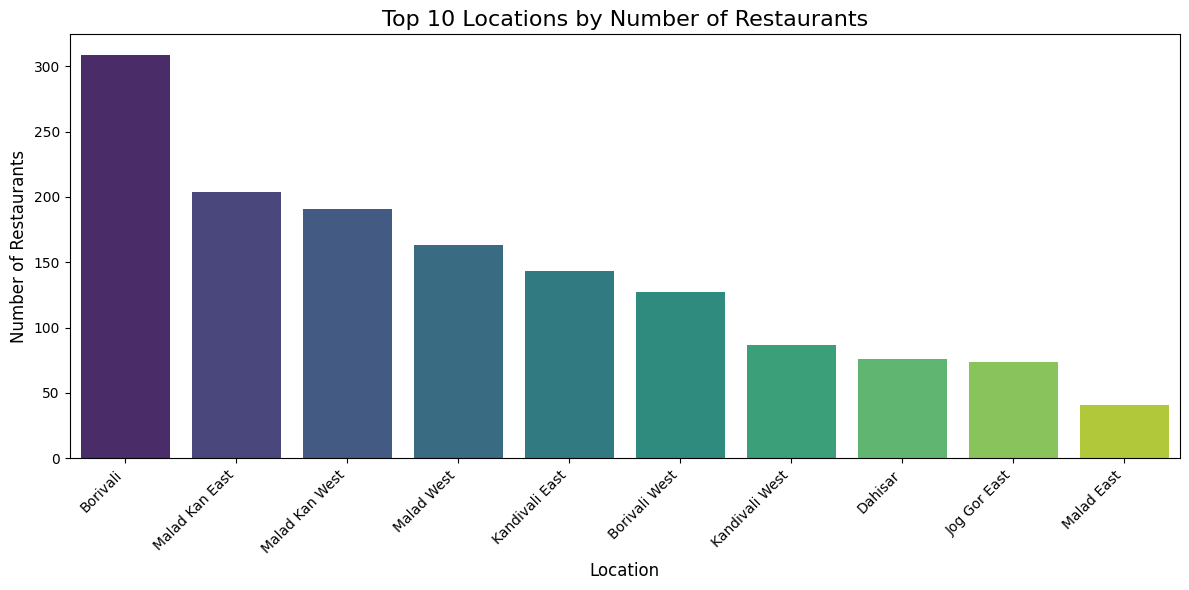

In [18]:
# --- 4. Visualizations ---

print("\n--- Data Visualizations ---")

# 1. Bar plot: Top 10 Locations by Restaurant Count
plt.figure(figsize=(12, 6))
top_locations = df_clean['location'].value_counts().head(10)
sns.barplot(x=top_locations.index, y=top_locations.values, palette='viridis')
plt.title('Top 10 Locations by Number of Restaurants', fontsize=16)
plt.xlabel('Location', fontsize=12)
plt.ylabel('Number of Restaurants', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


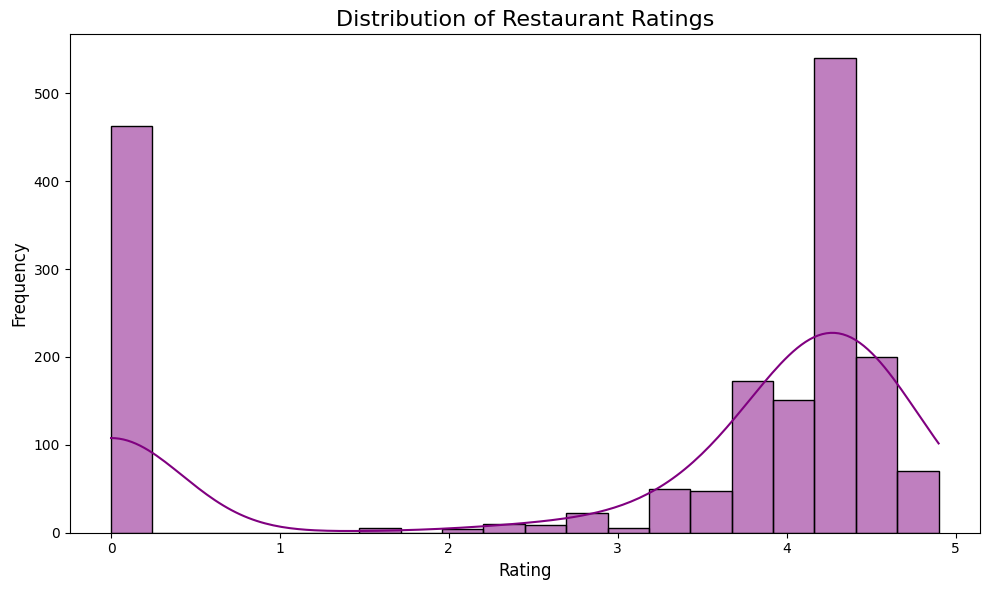

In [25]:
# 2. Histogram: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['rating'], bins=20, kde=True, color='purple')
plt.title('Distribution of Restaurant Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()


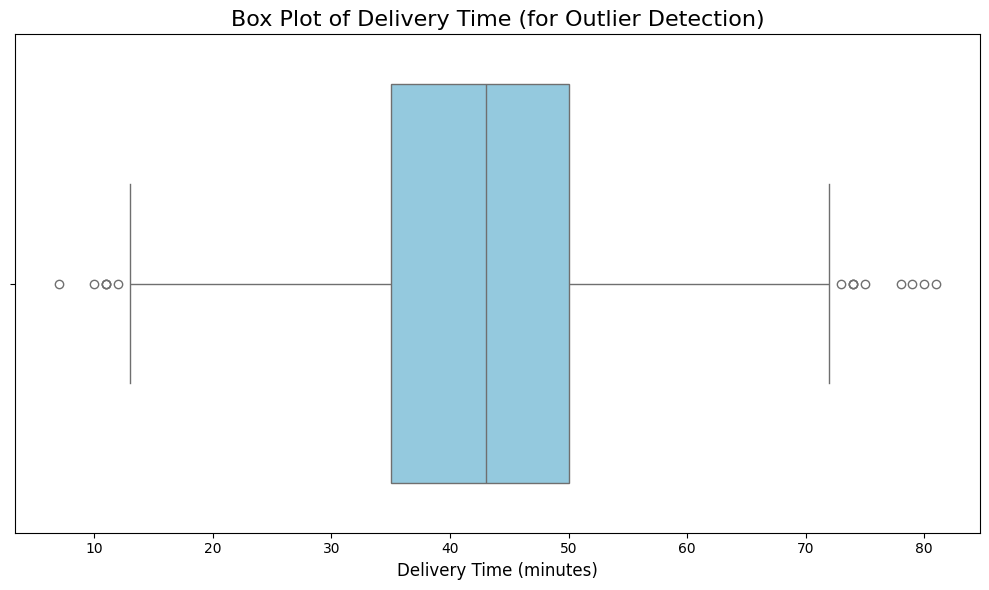

In [26]:
# 3. Box plot for outlier detection: Delivery Time
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_clean['delivery_time'], color='skyblue')
plt.title('Box Plot of Delivery Time (for Outlier Detection)', fontsize=16)
plt.xlabel('Delivery Time (minutes)', fontsize=12)
plt.tight_layout()
plt.show()


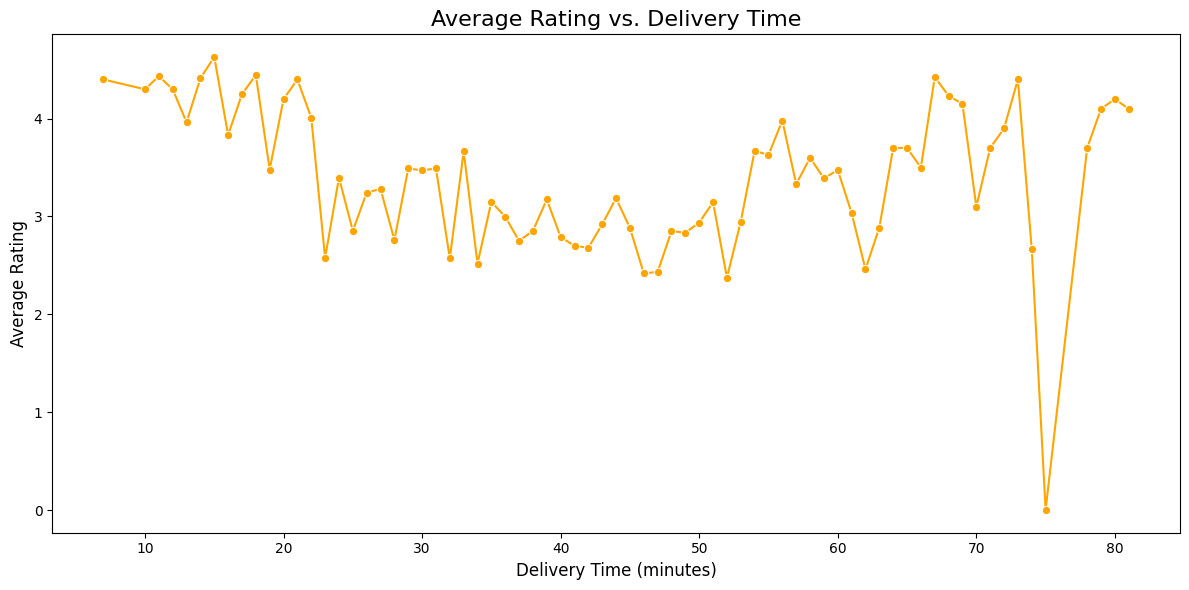

In [27]:
# 4. Line plot: Average Rating by Delivery Time
# We'll need to group by delivery time to get the average rating.
avg_rating_by_delivery = df_clean.groupby('delivery_time')['rating'].mean().reset_index()
# Filter out delivery times that might be outliers to make the plot clearer.
avg_rating_by_delivery = avg_rating_by_delivery[avg_rating_by_delivery['delivery_time'] < 100]
plt.figure(figsize=(12, 6))
sns.lineplot(x='delivery_time', y='rating', data=avg_rating_by_delivery, marker='o', color='orange')
plt.title('Average Rating vs. Delivery Time', fontsize=16)
plt.xlabel('Delivery Time (minutes)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.tight_layout()
plt.show()

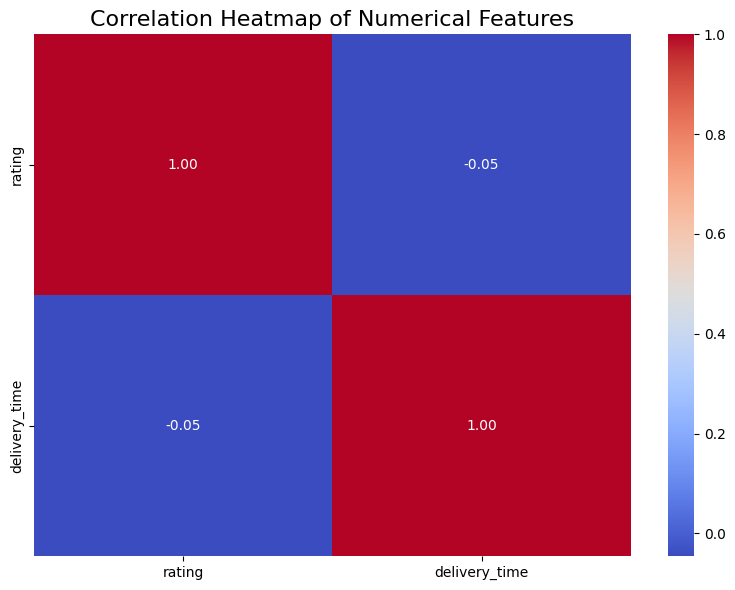

In [28]:
# 5. Heatmap: Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

C:\Users\91636\AppData\Local\Temp\ipykernel_10660\1520829249.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='cuisine', data=top_cuisines, palette='plasma')


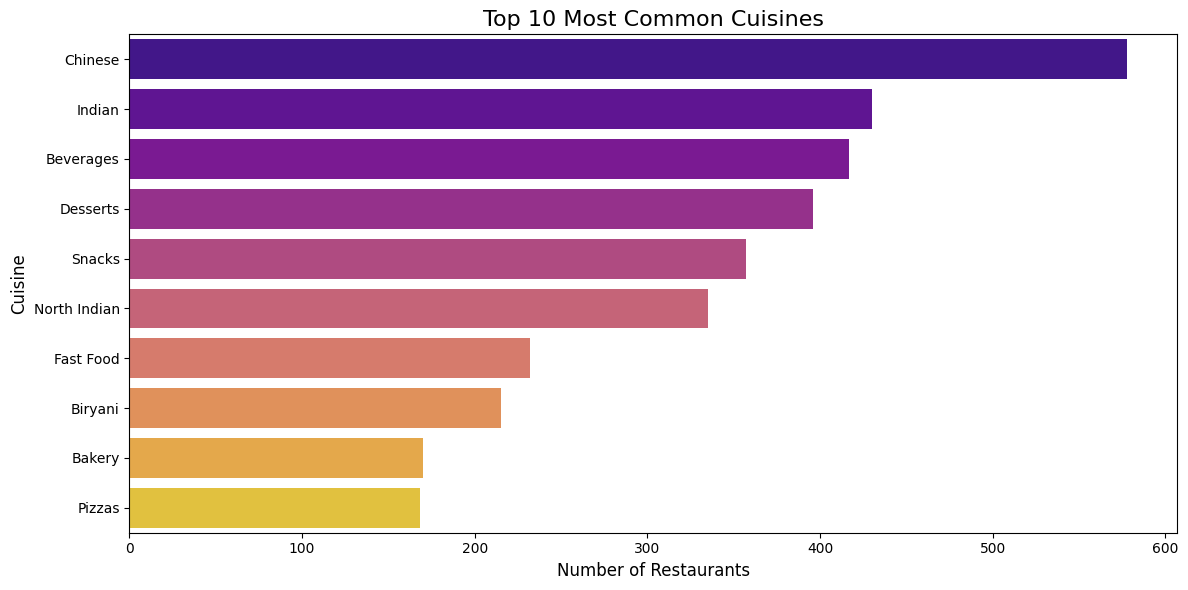

In [29]:
# 6. Bar Plot: Top 10 Most Common Cuisines
plt.figure(figsize=(12, 6))
top_cuisines = cuisine_counts.head(10)
sns.barplot(x='count', y='cuisine', data=top_cuisines, palette='plasma')
plt.title('Top 10 Most Common Cuisines', fontsize=16)
plt.xlabel('Number of Restaurants', fontsize=12)
plt.ylabel('Cuisine', fontsize=12)
plt.tight_layout()
plt.show()
